In [2]:
import pandas as pd
import janitor
import gc
from utilities.utils import get_fulldata
from utilities.graph_utils import conbarplot
from utilities.graph_utils import save_mpl_fig
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

FP_CASTE = '../data/hindi_eng_names_caste_outkast.csv.gz'

usecols = ['account_no', 'name_of_ryot', '6', '7', '8']
castes_cols = ['prop_sc', 'prop_st', 'prop_other']
df = (get_fulldata(**{'usecols':usecols})
      # Compute land area (in acres)
      .assign(tt_area_acre=lambda df: df['6']+df['7']/100+df['8']*2.4711)
      .remove_columns(['6', '7', '8'])
      # Get religion via hindi names
      .merge((pd.read_csv(FP_CASTE, usecols=['name']+castes_cols)
              .rename_column('name', 'name_of_ryot')
              .assign(pred_caste=lambda df: df[castes_cols].idxmax(axis=1))
              .remove_columns(castes_cols)
             ), how='left', on='name_of_ryot', validate='m:1'
            )
      .dropna(subset='pred_caste')
     )
df.shape

(269731, 4)

In [3]:
df.head(3)

,name_of_ryot,account_no,tt_area_acre,pred_caste
1,म.तजमुल हुसैन,701010001000003,0.56,prop_other
2,म.तजमुल हुसैन,701010001000003,0.00,prop_other
3,धर्मानाथ झा,701010001000010,0.00,prop_other


In [4]:
nplots_by_account = (df
                     .groupby(['account_no', 'pred_caste']).size().reset_index()
                     .rename_column(0, 'nplots')
                    )
print(f'{len(nplots_by_account)=:,}')
print(nplots_by_account.head(3))

len(nplots_by_account)=108,335
        account_no  pred_caste  nplots
0  101010273000001  prop_other       2
1  101010273000003  prop_other       1
2  101010273000004  prop_other       3


In [5]:
landarea_by_account = (df
                       .groupby(['account_no', 'pred_caste'])
                       .sum().reset_index()
                       .query('tt_area_acre>0')
                      )
print(f'{len(landarea_by_account)=:,}')
print(landarea_by_account.head(3))

len(landarea_by_account)=107,768
        account_no  pred_caste  tt_area_acre
0  101010273000001  prop_other         0.585
1  101010273000003  prop_other         0.080
2  101010273000004  prop_other         0.340


### Aggregate numbers

In [8]:
# Percentage of plots owned by Other
plots_owned_by_other = nplots_by_account.query('pred_caste=="prop_other"')['nplots'].sum()
tt_plots = nplots_by_account.nplots.sum()
pct_plot_owned_by_other = 100*(plots_owned_by_other/tt_plots)
print(f"Percentage of plots owned by SC Other: {pct_plot_owned_by_other:.1f}%")

Percentage of plots owned by SC Other: 92.0%


In [9]:
# Percentage of plots owned by SC
plots_owned_by_sc = nplots_by_account.query('pred_caste=="prop_sc"')['nplots'].sum()
tt_plots = nplots_by_account.nplots.sum()
pct_plot_owned_by_sc = 100*(plots_owned_by_sc/tt_plots)
print(f"Percentage of plots owned by SC: {pct_plot_owned_by_sc:.1f}%")

Percentage of plots owned by SC: 7.5%


In [10]:
# Percentage of plots owned by ST
plots_owned_by_st = nplots_by_account.query('pred_caste=="prop_st"')['nplots'].sum()
tt_plots = nplots_by_account.nplots.sum()
pct_plot_owned_by_st = 100*(plots_owned_by_st/tt_plots)
print(f"Percentage of plots owned by SC: {pct_plot_owned_by_st:.1f}%")

Percentage of plots owned by SC: 0.5%


### Number of plots

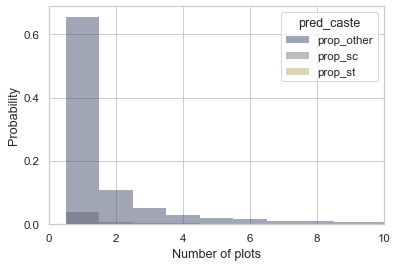

In [6]:
# Truncated > 90th percentile
sns.histplot(data=nplots_by_account, x="nplots", 
             hue='pred_caste',
             discrete=True,
             stat="probability", 
             palette='cividis'
            )
plt.xlabel('Number of plots')
plt.yticks([0,.2,.4,.6])
plt.xlim(0, 10)
save_mpl_fig('../figures/castes_outkast_number_plots')

Text(2, 2.0097744360902254, '(Diff. = -0.5)')

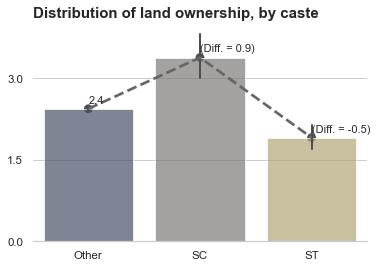

In [38]:
conbarplot(x='pred_caste', y='nplots', data=nplots_by_account, 
           grouplab='pred_caste', groups=['prop_other', 'prop_sc', 'prop_st'],
           annote_scaler=.1,
           xticklabels=['Other', 'SC', 'ST'],
           title='Distribution of land ownership, by caste'
          )    
st_minus_other = (nplots_by_account.query("pred_caste=='prop_st'")['nplots'].mean() 
                  - nplots_by_account.query("pred_caste=='prop_other'")['nplots'].mean())
grp3 = nplots_by_account.query("pred_caste=='prop_st'")['nplots'].mean()
plt.text(
    x=2,
    y=grp3 + .1,
    s=f"(Diff. = {st_minus_other:.1f})",
    ha="left",
    fontsize=11,
)
save_mpl_fig('../figures/castes_outkast_barplot_plots')

### Land area

In [39]:
landarea_by_account = (df
                       .groupby(['account_no', 'pred_caste'])
                       .sum().reset_index()
                       .query('tt_area_acre>0')
                      )
del df
gc.collect()
print(f'{len(landarea_by_account)=:,}')
print(landarea_by_account.head(3))

len(landarea_by_account)=107,768
        account_no  pred_caste  tt_area_acre
0  101010273000001  prop_other         0.585
1  101010273000003  prop_other         0.080
2  101010273000004  prop_other         0.340


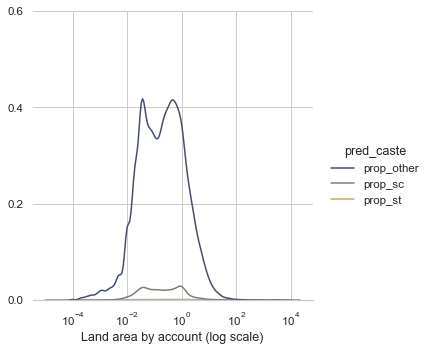

In [40]:
sns.displot(data=landarea_by_account,
            x='tt_area_acre',
            kind='kde',
            hue='pred_caste',
            log_scale=True,
            palette='cividis',
            cut=0
            )
plt.ylabel('')
plt.xlabel('Land area by account (log scale)')
plt.yticks([0,.2,.4,.6])
sns.despine(left=True)
save_mpl_fig('../figures/castes_outkast_plot_area')

Text(2, 0.7865494467477214, '(Diff. = -2.5)')

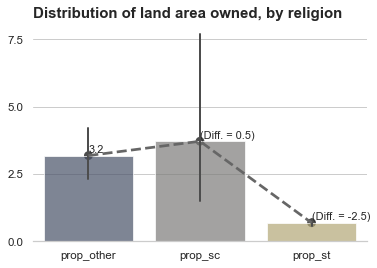

In [47]:
conbarplot(x='pred_caste', y='tt_area_acre', data=landarea_by_account, 
           grouplab='pred_caste', groups=['prop_other', 'prop_sc', 'prop_st'],
           annote_scaler=.1,
           xticklabels=['prop_other', 'prop_sc', 'prop_st'],
           title='Distribution of land area owned, by religion'
          )    
st_minus_other = (landarea_by_account.query("pred_caste=='prop_st'")['tt_area_acre'].mean() 
                  - landarea_by_account.query("pred_caste=='prop_other'")['tt_area_acre'].mean())
grp3 = landarea_by_account.query("pred_caste=='prop_st'")['tt_area_acre'].mean()
plt.text(
    x=2,
    y=grp3 + .1,
    s=f"(Diff. = {st_minus_other:.1f})",
    ha="left",
    fontsize=11,
)
save_mpl_fig('../figures/castes_outkast_barplot_plotarea')